In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import copy
#conda install -c conda-forge cufflinks-py
#conda install plotly
import ipywidgets as wg
from IPython.display import display

import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import inspect
import seaborn as sns

from matplotlib import pyplot as plt
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import TransformerMixin, BaseEstimator
pd.options.display.max_columns = 200
pd.options.display.max_rows = 272

In [2]:
from sklearn.feature_selection import SelectKBest, VarianceThreshold, RFE, SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from joblib import dump, load
from Logger import RegressionLogger, FuncTransformer, ColSelect

In [3]:
import inspect

In [4]:
log_transformed = 0      

In [5]:
model_log = load("data/model_logging.joblib")

In [6]:
while len(model_log) > 1:
    model_log.pop()

In [7]:
current_model = copy.deepcopy(model_log[0]["model"])

# Now Lets Load our original Data

In [8]:
df = pd.read_csv("data/cleaned_df.csv", index_col="UnitID")

In [9]:
df.drop("Unnamed: 0",axis=1, inplace=True)

In [10]:
df.drop(["City location of institution (HD2019)", "Institution Name"], axis=1, inplace=True)

In [11]:
X = df.iloc[:, :-14]
y = df.iloc[:,-14]

In [12]:
df_black = df.dropna(subset=[df.columns[-7]])

In [13]:
X_black = df_black.iloc[:,:-14]
y_black = df_black.iloc[:, -7]

In [14]:
X_black = pd.get_dummies(X_black, drop_first=True)

In [15]:
X = pd.get_dummies(X, drop_first=True)

In [16]:
X.shape

(2315, 260)

In [17]:
X_black.shape

(2027, 255)

# Lets Define Our Pipeline

In [18]:
num_feats = 200
num_pipe = Pipeline([
    ('Impute', ColumnTransformer([
        ('Impute', KNNImputer(n_neighbors=5), make_column_selector(dtype_include=[np.float16, 'float']))
    ], remainder='drop'
    )),
    ('Scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('Passthrough', ColumnTransformer([
        ('Pass', 'passthrough', make_column_selector(dtype_exclude='float'))
    ], remainder='drop'
    ))
])

preprocessor = FeatureUnion([
    ('numeric', num_pipe),
    ('categorical', cat_pipe)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

In [19]:
params = {
    "Imputer": "KNNImputer",
    "Scaler": "Standard Scaler",
    "model_name": "Elastic Net",
    "model": pipeline,
    "alpha": 0.1,
    "l1_ratio": 0.5,
}

In [20]:
logger = RegressionLogger(params)

In [21]:
logger.train_update(pipeline, X, y)

In [22]:
logger.train_mae, logger.mae

(9.889907417942231, 9.47909355242729)

In [23]:
logger.save_log("KNN Imputation")

In [24]:
model_log.append(logger.record())

# Currently Our Train is Worse then our test set due to very poor features


<ol>
    <li>Lets Visualize our current residuals</li>
    <li>Find trends to improve those residuals</li>
    <li>See if our feature engineering improves residual plots</li>
<ol>

In [25]:
residuals = logger.y_pred - logger.y_test

In [26]:
resid_data = {
    'y_test': logger.y_test,
    'residuals':residuals,
}

In [27]:
residual_data = pd.DataFrame(resid_data)

In [28]:
fig = px.scatter(residual_data, x='y_test', y='residuals')

fig.show()

# Lets Create a New DataFrame Feature Engineered Features

In [29]:
X_fe = X.copy(deep=True)

In [30]:
fig = make_subplots(
    rows=1, cols=2, 
    column_widths=[0.6, 0.4],
    subplot_titles=['Core Revenue vs Graduation Rates', 'Core Revenues vs Residuals']
)

_ = fig.add_trace(go.Scatter(
    x = logger.x_test["Core_Revenues"], y=residual_data['y_test'], mode='markers'
),1,1)

_ = fig.add_trace(go.Scatter(
    x = X_fe["Core_Revenues"], y=residual_data['residuals'], mode='markers'
), 1, 2)

fig.update_layout(
    xaxis = {
        'title': 'Core_Revenues'
    },
    xaxis2 = {
        'title': 'Core_Revenues'
    },
    yaxis = {
        'title': 'Graduation_Rates'
    },
    yaxis2 = {
        'title': 'Residuals'
    },
    
)
   
fig.show()

### Lets fit a log function through core revenues

In [31]:
transformer = FuncTransformer()

In [32]:
X_fe['Log_Core_Revenues'] = transformer.log_transform(X_fe.to_numpy(), 0)

In [33]:
fig = make_subplots(
    rows=1, cols=2, 
    column_widths=[0.6, 0.4],  
)
    
_ = fig.add_trace(go.Scatter(
    x = X_fe["Log_Core_Revenues"], y=y, mode='markers'
),1,1)

_ = fig.add_trace(go.Scatter(
    x = X_fe["Log_Core_Revenues"], y=residual_data['residuals'], mode='markers'
), 1, 2)

   
fig.show()

In [34]:
logger.train_update(pipeline, X_fe, y)
logger.train_mae, logger.mae

(9.878095103258842, 9.462263320693712)

# Log Core Expenses

In [35]:
X_fe['Log_Core_Expenses'] = transformer.log_transform(X_fe.to_numpy(), X_fe.columns.get_loc('Core_Expenses'))

In [36]:
logger.train_update(pipeline, X_fe, y)
logger.train_mae, logger.mae

(9.878452011572808, 9.456572910662574)

## It Improves training but not test set so lets do a few more trends to see if we get a significant difference.

In [37]:
# transforming all dollar amounts to log dollar amounts
for i in X_fe.filter(regex='As_Dollar').columns:
    # replace 0s with 1s to avoid errors with logs
    X_fe[i].replace({0.0: 1.0}, inplace=True)
    iloc = X_fe.columns.get_loc(i)
    X_fe["Log_" + i] = transformer.log_transform(X_fe.to_numpy(), iloc)

In [38]:
logger.train_update(pipeline, X_fe, y)

In [39]:
logger.train_mae, logger.mae

(9.784750873763379, 9.437546805036328)

# Small Improvements with Log Dollar Amounts

### Schools with graduation rates of 0 and 100 are always outliers. Lets drop those observations to see if we get some improvement

### (It improved the model, but I wound up commenting out it because I want the model to work for all schools not just ones without a 0% or 100% graduation rate)

In [40]:
# to_drop = list(y[y==100].index) + list(y[y==0].index)

In [41]:
# X_fe.drop(to_drop, inplace=True)

In [42]:
# y.drop(to_drop, inplace=True)

In [43]:
# X.drop(to_drop, inplace=True)

In [44]:
# logger.train_update(pipeline, X_fe, y)
# logger.train_mae, logger.mae

# Significant improvement with dropped outlier graduation rates

In [45]:
new_residuals = logger.y_pred - logger.y_test
new_resid_data = {
    'y predicted': logger.y_pred,
    'residuals':new_residuals,
}
new_residual_df = pd.DataFrame(new_resid_data)

In [46]:
fig = px.scatter(new_residual_df, x='y predicted', y='residuals', title='Total Graduation Rate Residuals')

fig.show()

# Still not a visible Improvement in our residual plots

### Next Steps
<ol>
    <li>Create Polynomial Features</li>
    <li>Select the Best Polynomial Features</li>
    <li>Add them to my model one by one to see if any further improvement is possible</li>
<ol>

In [47]:
polyfeatures = Pipeline([
    ('preprocess', preprocessor),
    ('polyfeatures', PolynomialFeatures()),
    ('classifier', ElasticNet(alpha=0.1, l1_ratio=0.5))
])

In [48]:
logger.train_update(polyfeatures, X_fe, y)

/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10555.319452493699, tolerance: 100.9455618819011



In [49]:
new_params = {
    'model'
    'imputer': "KNNImputer",
    'polyfeatuers': "Polynomial Features",
    "model_name": "Elastic Net",
    "model": polyfeatures
}

In [50]:
logger.train_mae, logger.mae

(5.208087206921563, 10.00512786775969)

Significant Improvement in training data but model does not converge due to very large amount of features: lets look at the best features and add them one by one to our model

In [51]:
feature_names = polyfeatures['polyfeatures'].get_feature_names(X_fe.columns)
coefs = polyfeatures['classifier'].coef_

In [52]:
best_coefs = sorted(list(zip(feature_names, coefs)), key= lambda x: np.abs(x[1]))

In [53]:
# Make polynomial features data frame
poly_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('polyfeatures', PolynomialFeatures()),
])
poly_data = poly_pipeline.fit_transform(X_fe)
poly_features_df = pd.DataFrame(poly_data, columns=feature_names)

In [54]:
X_fe[best_coefs[-1][0]] = poly_features_df[best_coefs[-1][0]].to_numpy()

In [55]:
new_params = {
    'model'
    'imputer': "KNNImputer",
    'polyfeatuers': "Polynomial Features",
    "model_name": "Elastic Net",
    "model": polyfeatures
}

logger.__init__(new_params)

In [56]:
logger.train_update(pipeline, X_fe, y)

logger.save_log("Polynomial features added")
model_log.append(logger.record())
logger.train_mae, logger.mae

(9.720690291108491, 9.45058224062999)

# This New Feature Helped so lets continue adding features until model stops improving

#### I am only choosing features that are new combinations, instead of features I already have

In [57]:
best_coefs[-7][0]

'Total women (EF2013B_RV  Undergraduate  Age 25 and over total)_as_percentage'

In [58]:
X_fe[best_coefs[-7][0]] = poly_features_df[best_coefs[-7][0]].to_numpy()

In [59]:
logger.train_update(pipeline, X_fe, y)
logger.train_mae, logger.mae

(9.712213209313694, 9.457301621091888)

## Improved Training but test did not improve. Lets keep adding to be sure

In [60]:
best_coefs[-8][0]

'Institutional_Support_Expenses State abbreviation (HD2018)_District of Columbia'

In [61]:
X_fe[best_coefs[-8][0]] = poly_features_df[best_coefs[-8][0]].to_numpy()

In [62]:
logger.train_update(pipeline, X_fe, y)
logger.train_mae, logger.mae

(9.686269679094284, 9.483851684434343)

### Ok Our Model Is clearly moving in the other direction now so lets remove the last two features and use these features for our final model

In [63]:
X_fe.drop(X_fe.columns[-2:].to_list(), axis=1, inplace=True)

In [64]:
logger.train_update(pipeline, X_fe, y)
logger.train_mae, logger.mae

(9.784322298381673, 9.430176181535645)

# Lets Use the top 250 features that came from polyfeatures and train a model

In [65]:
best_features = [i[0] for i in best_coefs[-250:]]

In [66]:
X_coefs = poly_features_df[best_features]

In [67]:
logger.train_update(pipeline, X_coefs, y)
logger.train_mae, logger.mae

(7.731983535943396, 9.956410554309224)

In [68]:
logger.train_update(pipeline, X_fe, y)

logger.save_log("top 250 polyfeatures used")
model_log.append(logger.record())
logger.train_mae, logger.mae

(9.784322298381673, 9.430176181535645)

# Hyperparameter Tuning

### Next steps
<ol>
    <li>Manual tuning</li>
    <li>Define hyperparameter space to search over</li>
    <li>Repeat with XGBRegressor</li>
<ol>

### With A few Manual Adjustments these are the parameters that work well

In [69]:
elasticNet_model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', ElasticNet(alpha=0.02, l1_ratio=0.8))
])

In [70]:
new_params = {
    "Imputer": "KNNImputer",
    "model_name": "Elastic Net",
    "model": elasticNet_model,
    'alpha': 0.3,
    'l1_ratio': 0.8,
}

In [71]:
logger.__init__(new_params)
logger.train_update(elasticNet_model, X_fe, y)
logger.save_log("Tuned Elstic Net Model")
model_log.append(logger.record())

In [72]:
logger.mae

9.509087759374909

# Lets Test Tree based models; Lets Start With a RandomForest

In [73]:
rf_params = {
    'n_estimators': 150,
    'max_depth': 18, # max allowed depth of trees
    'min_samples_leaf': 3, # min number of data points allowed in a leaf node
}

In [74]:
rf = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestRegressor(**rf_params))
])

In [75]:
rf_log_params = {
    'Imputer': 'KNNImputer',
    'model_name': "Random Forest",
    'model': rf,
    'n_estimators': 150,
    'max_depth': 15, 
    'min_samples_leaf': 7, 
}

In [76]:
logger.__init__(rf_log_params)
logger.train_update(rf, X_fe, y)
logger.save_log("Tuned Random Forest")
model_log.append(logger.record)

In [77]:
logger.train_mae, logger.mae

(4.376654177636321, 8.297320642704003)

# XGBRegressor Tree Based Model

In [78]:
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'max_depth': 10, # lower values will over fit
    'learning_rate': 0.1, 
}

In [79]:
xgb_model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', xgb.XGBRegressor(**xgb_params))
])

In [80]:
logger.train_update(xgb_model, X_fe, y)

In [81]:
logger.train_mae, logger.mae

(0.525533112149598, 8.66956217535611)

### Severe overfitting with XGB model training_mae is only 0.38
lets modify the parameters to reduce overfitting

In [82]:
xgb_params['max_depth'] = 7 # how deep each tree is allowed to be
xgb_params['learning_rate'] = 0.07 # how fast the model converges
xgb_params['colsample_bytree'] = 0.8 # percentage of features to work with per tree
xgb_params['colsample_bynode'] = 0.9 # percentage of remaining features to work with for each split
xgb_params['alpha'] = 0.9 # L1 regularization parameter
xgb_params['gamma'] = 0.7 # minimum loss required for a split to occur
xgb_params['min_child_weight'] = 10 # stop splitting once the number of samples in a given node hits a certain threshold
xgb_params['n_estimators'] = 200
xgb_params['importance_type'] = 'gain'
xgb_model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', xgb.XGBRegressor(**xgb_params))
])

In [83]:
xgb_log_params = {
    'Imputer': "KNNImputer",
    'model_name': "XGBRegressor",
    'model': xgb_model,
    'objective': 'reg:squarederror',
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.07,
    'colsample_bytree': 0.8,
    'colsample_bynode': 0.9,
    'alpha': 0.9,
    'gamma': 0.7,
    'min_child_weight': 10,
    'importance_type': 'gain'   
}

In [84]:
logger.__init__(xgb_log_params)
logger.train_update(xgb_model, X_fe, y)
logger.save_log("Tuned XGB Model")
model_log.append(logger.record())

In [85]:
logger.train_mae, logger.mae

(2.3448957301536777, 8.214601056329135)

# 8.2% MAE is the accuracy we are able to achieve through intuition and manual tuning. Lets Create a parameter space around these values

In [86]:
hyperparams = {
    'classifier__objective': ['reg:squarederror'],
    'classifier__n_estimators': np.arange(50,300, 50),
    'classifier__max_depth': np.arange(5,11, 1),
    'classifier__learning_rate': np.arange(0.05, 0.16, 0.01),
    'classifier__colsample_bytree': np.arange(0.6, 1.0, 0.1),
    'classifier__colsample_bynode': np.arange(0.6, 1.0, 0.1),
    'classifier__alpha': np.arange(0.6, 1.0, 0.05),
    'classifier__gamma': np.arange(0.6, 1.0, 0.05),
    'classifier__min_child_weight': [1,5,10,15,20, 25]}

In [87]:
MAE = make_scorer(mean_absolute_error)

In [88]:
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=hyperparams, n_iter=1,
    scoring=MAE, n_jobs=4, cv=3, verbose=3, 
    random_state=1001 )

In [89]:
_ = random_search.fit(X_fe, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [90]:
random_search.best_params_

{'classifier__objective': 'reg:squarederror',
 'classifier__n_estimators': 200,
 'classifier__min_child_weight': 20,
 'classifier__max_depth': 10,
 'classifier__learning_rate': 0.060000000000000005,
 'classifier__gamma': 0.8500000000000002,
 'classifier__colsample_bytree': 0.7,
 'classifier__colsample_bynode': 0.7,
 'classifier__alpha': 0.65}

In [91]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__objective,param_classifier__n_estimators,param_classifier__min_child_weight,param_classifier__max_depth,param_classifier__learning_rate,param_classifier__gamma,param_classifier__colsample_bytree,param_classifier__colsample_bynode,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.419831,0.226354,0.489404,0.05173,reg:squarederror,200,20,10,0.06,0.85,0.7,0.7,0.65,"{'classifier__objective': 'reg:squarederror', ...",10.29626,9.703935,10.233613,10.077936,0.265693,1


In [92]:
random_search.best_score_

10.077935991301032

## These parameters performed worse than my own manual tuning lets use the first Model as our final model

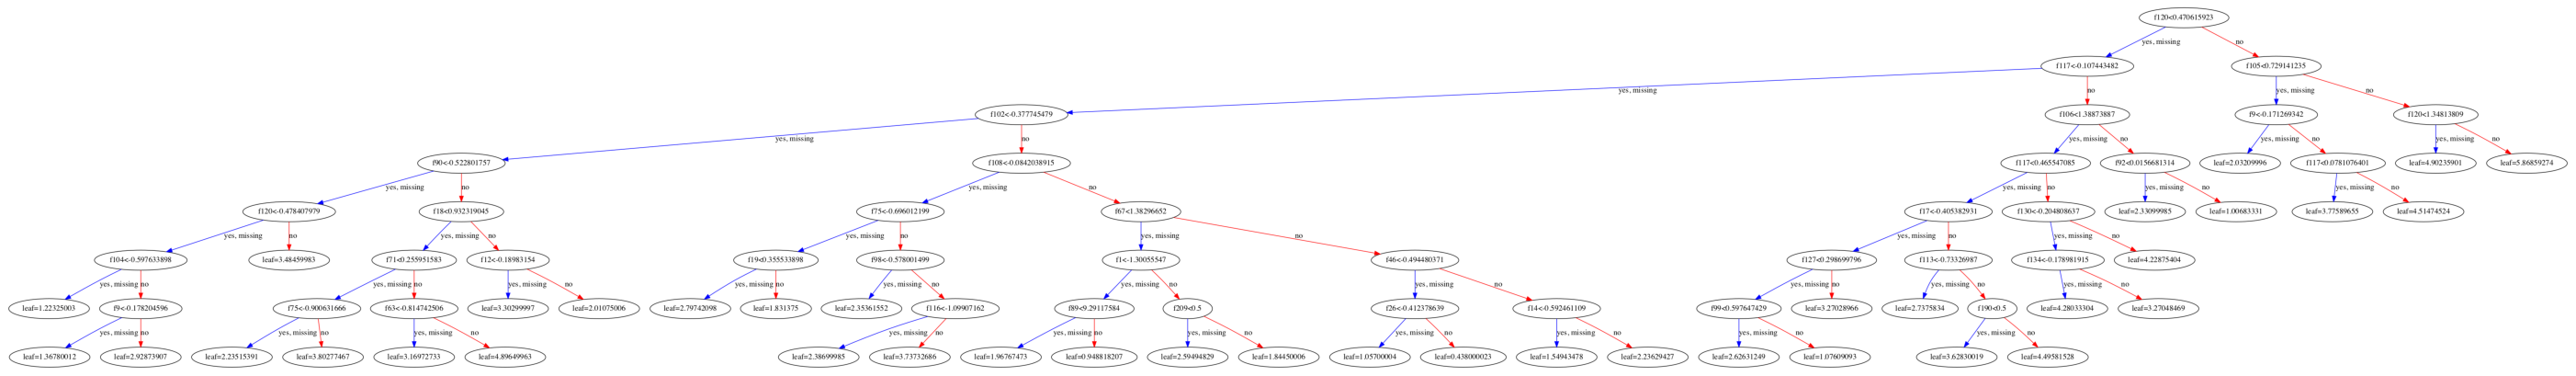

In [93]:
xgb.plot_tree(xgb_model['classifier'], num_trees=0)
fig = plt.gcf()
fig.set_size_inches(50, 20)

# Old Features Against Target

In [94]:
picker1 = wg.Dropdown(
    options=X.columns,
    value=X.columns[0],
    description='Feature:',
    disabled=False,
)


ui = wg.HBox([picker1])


def scatter_residuals(feature):
    fig = make_subplots(
    rows=1, cols=2, 
    column_widths=[0.6, 0.4],
    subplot_titles=(feature, "Residuals")
    )


    _ = fig.add_trace(go.Scatter(
        x = X[feature], y=y, mode='markers'
    ),1,1)

    _ = fig.add_trace(go.Scatter(
        x = X[feature], y=residual_data['residuals'], mode='markers'
    ), 1, 2)
    
    display(fig.show())
    
out = wg.interactive_output(scatter_residuals, {'feature': picker1})
out.layout.height = '700px'
_ = display(ui, out)

Output(layout=Layout(height='700px'))

# New Features Against Target

In [95]:

picker1 = wg.Dropdown(
    options=X_fe.columns,
    value=X_fe.columns[0],
    description='Feature:',
    disabled=False,
)

ui = wg.HBox([picker1])

def scatter_residuals(feature):
    fig = make_subplots(
    rows=1, cols=2, 
    column_widths=[0.6, 0.4],
    subplot_titles=(feature, "Residuals")
    )


    _ = fig.add_trace(go.Scatter(
        x = X_fe[feature], y=y, mode='markers'
    ),1,1)

    _ = fig.add_trace(go.Scatter(
        x = X_fe[feature], y=new_residual_df['residuals'], mode='markers'
    ), 1, 2)
    
    display(fig.show())
    
out = wg.interactive_output(scatter_residuals, {'feature': picker1})
out.layout.height = '700px'
_ = display(ui, out)

Output(layout=Layout(height='700px'))

# Summary

Highest performing model was an xgb regressor; however, feature importances are much tougher to interperate than an elastic net model. In the end we have a model with mean absolute error of 8.35%. The features that have the strongest effect on graduation rates are shown below.

In [96]:
X_fe.columns = X_fe.columns.str.replace('Carnegie Classification', 'CC')

In [97]:
X_fe.columns = X_fe.columns.str.replace(' 2018:', '')

In [98]:
X_fe.filter(regex='CC')

,CC Basic (HD2018)_Associate's Colleges: High Transfer-Mixed Traditional/Nontraditional,CC Basic (HD2018)_Associate's Colleges: High Vocational & Technical-High Nontraditional,CC Basic (HD2018)_Associate's Colleges: High Vocational & Technical-High Traditional,CC Basic (HD2018)_Associate's Colleges: High Vocational & Technical-Mixed Traditional/Nontraditional,CC Basic (HD2018)_Associate's Colleges: Mixed Transfer/Vocational & Technical-High Nontraditional,CC Basic (HD2018)_Associate's Colleges: Mixed Transfer/Vocational & Technical-High Traditional,CC Basic (HD2018)_Associate's Colleges: Mixed Transfer/Vocational & Technical-Mixed Traditional/Nontraditional,CC Basic (HD2018)_Baccalaureate Colleges: Arts & Sciences Focus,CC Basic (HD2018)_Baccalaureate Colleges: Diverse Fields,CC Basic (HD2018)_Baccalaureate/Associate's Colleges: Associate's Dominant,CC Basic (HD2018)_Baccalaureate/Associate's Colleges: Mixed Baccalaureate/Associate's,CC Basic (HD2018)_Doctoral Universities: High Research Activity\r\n,CC Basic (HD2018)_Doctoral Universities: Very High Research Activity\r\n,CC Basic (HD2018)_Doctoral/Professional Universities\r\n,CC Basic (HD2018)_Master's Colleges & Universities: Larger Programs,CC Basic (HD2018)_Master's Colleges & Universities: Medium Programs,CC Basic (HD2018)_Master's Colleges & Universities: Small Programs,"CC Basic (HD2018)_Not applicable, not in Carnegie universe (not accredited or nondegree-granting)","CC Basic (HD2018)_Special Focus Four-Year: Arts, Music & Design Schools",CC Basic (HD2018)_Special Focus Four-Year: Business & Management Schools,CC Basic (HD2018)_Special Focus Four-Year: Engineering Schools,CC Basic (HD2018)_Special Focus Four-Year: Faith-Related Institutions,CC Basic (HD2018)_Special Focus Four-Year: Medical Schools & Centers,CC Basic (HD2018)_Special Focus Four-Year: Other Health Professions Schools,CC Basic (HD2018)_Special Focus Four-Year: Other Special Focus Institutions,CC Basic (HD2018)_Special Focus Four-Year: Other Technology-Related Schools,CC Basic (HD2018)_Special Focus Two-Year: Arts & Design,CC Basic (HD2018)_Special Focus Two-Year: Health Professions,CC Basic (HD2018)_Special Focus Two-Year: Other Fields,CC Basic (HD2018)_Special Focus Two-Year: Technical Professions,CC Basic (HD2018)_Tribal Colleges,CC Basic (HD2018)_isMissing,CC Enrollment Profile (HD2018)_Exclusively undergraduate four-year,CC Enrollment Profile (HD2018)_Exclusively undergraduate two-year,CC Enrollment Profile (HD2018)_High undergraduate,CC Enrollment Profile (HD2018)_Majority graduate,CC Enrollment Profile (HD2018)_Majority undergraduate,"CC Enrollment Profile (HD2018)_Not applicable, not in Carnegie universe (not accredited or nondegree-granting)",CC Enrollment Profile (HD2018)_Very high undergraduate,CC Enrollment Profile (HD2018)_isMissing,"CC Size and Setting (HD2018)_Four-year, large, highly residential","CC Size and Setting (HD2018)_Four-year, large, primarily nonresidential","CC Size and Setting (HD2018)_Four-year, large, primarily residential","CC Size and Setting (HD2018)_Four-year, medium, highly residential","CC Size and Setting (HD2018)_Four-year, medium, primarily nonresidential","CC Size and Setting (HD2018)_Four-year, medium, primarily residential","CC Size and Setting (HD2018)_Four-year, small, highly residential","CC Size and Setting (HD2018)_Four-year, small, primarily nonresidential","CC Size and Setting (HD2018)_Four-year, small, primarily residential","CC Size and Setting (HD2018)_Four-year, very small, highly residential","CC Size and Setting (HD2018)_Four-year, very small, primarily nonresidential","CC Size and Setting (HD2018)_Four-year, very small, primarily residential","CC Size and Setting (HD2018)_Not applicable, not in Carnegie universe (not accredited or nondegree-granting)","CC Size and Setting (HD2018)_Two-year, large","CC Size and Setting (HD2018)_Two-year, medium","CC Size and Setting (HD2018)_Two-year, small","CC Size and Setting (HD2018)_Two-year, very large","CC Si

In [99]:
coefs = elasticNet_model['classifier'].coef_
feature_names = list(X_fe.columns)
final_coefs = sorted(list(zip(feature_names, coefs)), key= lambda x: np.abs(x[1]))

In [100]:
dump(feature_names, "data/feature_names.joblib")

['data/feature_names.joblib']

In [101]:
best = final_coefs[-10:]

In [102]:
best = sorted(best, key=lambda x: x[1])

In [103]:
fig = make_subplots(rows=1, cols=1, subplot_titles=["Model Coeficients"])

fig.add_trace(
    go.Bar(x=[i[1] for i in best], y=[i[0] for i in best], 
           orientation='h', text=[round(i[1], 2) for i in best]),
    1, 1)

fig.update_yaxes(
    tickangle = 10
)
fig.show()

In [104]:
logger.train_update(elasticNet_model, X_fe, y)

In [105]:
fig = make_subplots(rows=1, cols=1, subplot_titles=["Predicted Vs Actual"])

fig.add_trace(
    go.Scatter(x=logger.y_pred, y=logger.y_test, mode='markers', name='Pred vs. Actual'),
    1, 1)

fig.add_trace(
    go.Scatter(x=np.arange(0,100,1), y=np.arange(0,100,1), mode='lines', name='100 % acc')
)

fig.update_layout(
    title="Model Performance",
    xaxis_title="Predicted Graduation Rate",
    yaxis_title="Actual Graduation Rate",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=16,
    )
)

fig.show()

In [106]:
dump(model_log, "data/model_logging.joblib")

['data/model_logging.joblib']

In [107]:
dump(X_fe, "data/features.joblib")

['data/features.joblib']